# 02. Neural Network Classification with PyTorch

Classification is the problem of predicting whether something is one thing or another (there can be multiple things as options).



## 1. Making classification data and getting it ready

In [51]:
import sklearn
from sklearn.datasets import make_circles

In [52]:
# Make 1000 samples.
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

The make circles dataset is a binary classification problem. X contains 2 features which indicate the location of a point. The make circles dataset creates 2 circles from many points. We have to classify our points if they belong to one circle or the other.

In [53]:
len(X), len(y)  # 1000 samples of x and y.

(1000, 1000)

In [54]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [55]:
print(f'First 5 samples of X:\n {X[:5]}') # We have 2 values in x
print(f'First 5 samples of y:\n {y[:5]}') # We have 1 output y.

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


The output y has only 2 options --> 0 and 1. So it looks like it's a binary classification problem.

In [56]:
# Make dataframe of the circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


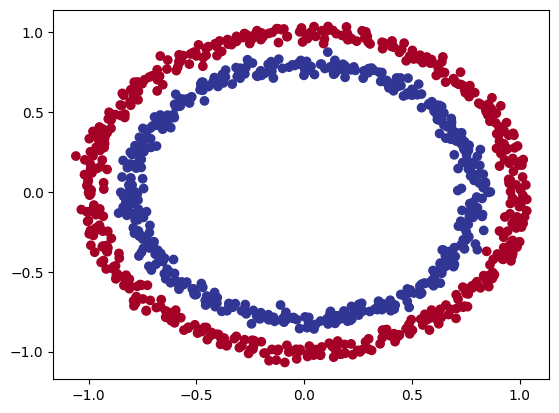

In [57]:
# Visualizing to better understand the data.
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,  # color it with labels. y represents the color, 0 and 1 being blue and red
            cmap=plt.cm.RdYlBu)

The type of dataset we're working on is what people a toy dataset. A dataset which is small enough to experiment but still sizeable enough to practice the fundamentals. More about the dataset --> [`sklearn.make_circles`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)

### 1.1 Check input and output shapes

In [58]:
X.shape, y.shape

((1000, 2), (1000,))

In [59]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Value for one sample of X: {X_sample}. Value for one sample of y: {y_sample}')
print(f'Shape for 1 sample of X: {X_sample.shape}. Shape of one sample of y: {y_sample.shape}')

Value for one sample of X: [0.75424625 0.23148074]. Value for one sample of y: 1
Shape for 1 sample of X: (2,). Shape of one sample of y: ()


y is a scalar. It doesn't have a dimension.

### 1.2 Turn data into tensor and create train and test splits

In [60]:
import torch
torch.__version__

'2.1.0+cu121'

In [61]:
X.dtype

dtype('float64')

In [62]:
# Make device agnostic code.
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cpu'

In [63]:
# Turning data into tensors.
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [64]:
torch.manual_seed(42) # Setting pytorch's seed to 42

In [65]:
# Split data into training and test splits.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [66]:
type(X_test), X_train.dtype, y_test.dtype

(torch.Tensor, torch.float32, torch.float32)

In [67]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

# 2. Building a model

Let's build a model to classify our red and blue dots.

To do that we need to -
- Set up our device agnostic code so code can run on GPU
- Construct a custom model (by subclassing `nn.Module`)
- Define a loss function and optimizer
- Create a training and testing loop

In [68]:
# Import PyTorch and nn
import torch
import torch.nn as nn

# Make device agnostic code.
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cpu'

In [69]:
X_train, X_train.shape

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         ...,
         [ 0.0157, -1.0300],
         [ 1.0110,  0.1680],
         [ 0.5578, -0.5709]]),
 torch.Size([800, 2]))

After setting up the device agnostic code, lets create a model that:
1. Subclasses `nn.module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method for the forward pass.
4. Instantiate an instance of our model class and send it to the target `device`

In [70]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear() layers capable of handling the shapes of our data.
    # self.layer1 = nn.Linear(in_features=2, out_features=5) # Since x has 2 features, we give input as 2 nodes.
    # self.layer2 = nn.Linear(in_features=5, out_features=1) # We take the 5 nodes in hidden layer 1 and map it to the output layer which has only 1 node.

    # We can also use sequential here.
    self.two_linear_layers = nn.Sequential(
        nn.Linear(2, 5),
        nn.Linear(5,1)
    )

  # 3. Define the forward() method for our model
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    # output = self.layer2(self.layer1(x))
    output = self.two_linear_layers(x)
    return output

# 4. Instantiate the model of our class.
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [71]:
next(model_0.parameters()).device # Our model's parameters are on the cuda device.

device(type='cpu')

In [72]:
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('two_linear_layers.0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('two_linear_layers.1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('two_linear_layers.1.bias', tensor([-0.2060]))])

In [73]:
# Let's create a better model using nn.Sequential(). We will train this later.
model_X = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.Tanh(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to(device)

print(type(model_X))

<class 'torch.nn.modules.container.Sequential'>


In [74]:
model_X

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

We can also use sequential inside the init function, to stack up layers in a single variable.

In [75]:
model_X.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386],
                      [-0.6007,  0.5459],
                      [ 0.1177, -0.2296],
                      [ 0.4370,  0.1102],
                      [ 0.5713,  0.0773],
                      [-0.2230,  0.1900],
                      [-0.1918,  0.2976],
                      [ 0.6313,  0.4087],
                      [-0.3091,  0.4082],
                      [ 0.1265,  0.3591],
                      [-0.4310, -0.7000],
                      [-0.2732, -0.5424]])),
             ('0.bias',
              tensor([ 0.5802,  0.2037,  0.2929,  0.2236, -0.0123,  0.5534, -0.5024,  0.0445,
                      -0.4826,  0.2180, -0.2435,  0.2167, -0.1473,  0.5865, -0.4191, -0.4217])),
             ('2.weight',
              tensor([[-0.1491,  0.2249,  0.0833,  0.2406,

`squeeze()` reduces the dimension of the tensor to the lowest possible. Basically removes useless dimensions.

In [76]:
# Make predictions
model_0.eval()  # Put model into evaluation mode. Disabling batch norm, dropout etc.

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
  print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
  print(f'\nFirst 10 predictions as raw logits:\n{untrained_preds[:10]}')
  print(f'\nFirst 10 predictions:\n{torch.round(untrained_preds[:10]).squeeze()}')
  print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions as raw logits:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]])

First 10 predictions:
tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Our untrained model makes very bad predictions.

Logits: Logits are the output of the neural network without it being passed into the activation function.

So, if we apply sigmoid to the raw logits we get a continuous value between 0 and 1. After this, if we round it off, we get either 0 or 1.

### 2.1 Setup Loss and Optimizer
Since our problem is a binary classification task, we use the binary cross entropy function as our cost function.

We use normal stochastic gradient descent as our optimizer. We can also use Adam here and check out differences in performance between the two.

In PyTorch, we have two versions of BCE Loss -
* `nn.BCELoss()` --> requires inputs to have gone through a sigmoid activation function prior to input to BCELoss.
* `nn.BCELossWithLogits()` --> this has sigmoid activation built into it, so we don't want the output layer to have sigmoid if using this.

In our case, both model_0 and model_1 have the sigmoid function applied at the output, so we use `nn.BCELoss()`

In [77]:
# Picking a loss function and optimizer.
# criterion = nn.BCELoss() not using this since model 0 doesn't have sigmoid, outputs logits.
criterion = nn.BCEWithLogitsLoss()  # This has sigmoid activation built in.
optimizer = torch.optim.SGD(model_0.parameters(), 0.1)

In [78]:
# Calculating the accuracy -
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

# 3. Train Model

To train our model, we are going to build a training loop. It has the following steps -
1. Make prediction
2. Calculate loss
3. Set optimizer gradients to zero (`optimizer.zero_grad()`)
4. Calculate gradients of the loss (`loss.backward()`)
5. Update our parameters (`optimizer.step()`)

### 3.1 Converting raw logits to predictions (raw logits --> probability value --> prediction labels)

Before converting it, let's look at what our model currently outputs.



In [79]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])

In [80]:
# We'll convert these to probabilites using the sigmoid function.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]])

We now want to convert these probabilities to prediction labels. We round it off to do that. What we're doing is that we are setting 0.5 as the decision boundary. If the value of y is more than 0.5, we take 1 as output else we take 0 as output.

In [81]:
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [82]:
# Doing the 3 steps above in a single line.
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [83]:
# We want to get rid of the extra dimension. To do that -
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.])

In [84]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

Excellent! Our predictions tensor looks just like the test tensor so we can compare labels and calculate the loss.

### 3.2 Building a training and testing loop

In [85]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the hyperparameters
epochs = 1000

In [86]:
for epoch in range(epochs):
  # Setting model to train mode; activates tracking gradients
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Loss/Accuracy calculation
  # Since we're using BCEWithLogits loss, we have to give inputs as logits and loss function will apply sigmoid automatically.
  loss = criterion(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # Setting gradients to zero
  optimizer.zero_grad()

  # Calculating new gradients
  loss.backward()

  # Updating our parameters.
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass.
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculating test loss and accuracy
    test_loss = criterion(test_pred, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out information according to what's happening -
  if epoch%10 == 0:
    print(f'Epoch: {epoch+1} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

Epoch: 1 | Loss: 0.69569, Acc: 50.00% | Test Loss: 0.69315, Test Acc: 50.00%
Epoch: 11 | Loss: 0.69403, Acc: 50.00% | Test Loss: 0.69315, Test Acc: 50.00%
Epoch: 21 | Loss: 0.69343, Acc: 46.00% | Test Loss: 0.73848, Test Acc: 48.50%
Epoch: 31 | Loss: 0.69321, Acc: 49.00% | Test Loss: 0.75670, Test Acc: 47.50%
Epoch: 41 | Loss: 0.69312, Acc: 49.50% | Test Loss: 0.76650, Test Acc: 46.50%
Epoch: 51 | Loss: 0.69308, Acc: 50.38% | Test Loss: 0.76890, Test Acc: 46.50%
Epoch: 61 | Loss: 0.69306, Acc: 50.50% | Test Loss: 0.77130, Test Acc: 46.50%
Epoch: 71 | Loss: 0.69305, Acc: 50.50% | Test Loss: 0.77251, Test Acc: 46.50%
Epoch: 81 | Loss: 0.69304, Acc: 50.75% | Test Loss: 0.77251, Test Acc: 46.50%
Epoch: 91 | Loss: 0.69303, Acc: 50.38% | Test Loss: 0.77251, Test Acc: 46.50%
Epoch: 101 | Loss: 0.69302, Acc: 50.50% | Test Loss: 0.77251, Test Acc: 46.50%
Epoch: 111 | Loss: 0.69302, Acc: 50.62% | Test Loss: 0.77561, Test Acc: 46.00%
Epoch: 121 | Loss: 0.69301, Acc: 50.62% | Test Loss: 0.77871, T

Looks like our model isn't very good at learning. This is because we have a very basic linear model and we're not working with linear data. We will need more layers, activations to capture complex details in data.

## 4. Make predictions and evaluate the model

From the metrics, it looks like our model isn't learning that much. So, let's try to visualize predictions.

To do so, we're going to import a function called `plot_decision_boundary()` from the link - https://www.github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [87]:
import requests
from pathlib import Path

link = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'

if Path('helper_functions.py').is_file():
  print('The file download already exists, skipping download.')
else:
  print('Downloading helper_functions.py...')
  # Getting the data from the link.
  request = requests.get(link)

  # Creating the file and copying the content from the link into the file. wb --> write binary.
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

  print('Download Finished.')

The file download already exists, skipping download.


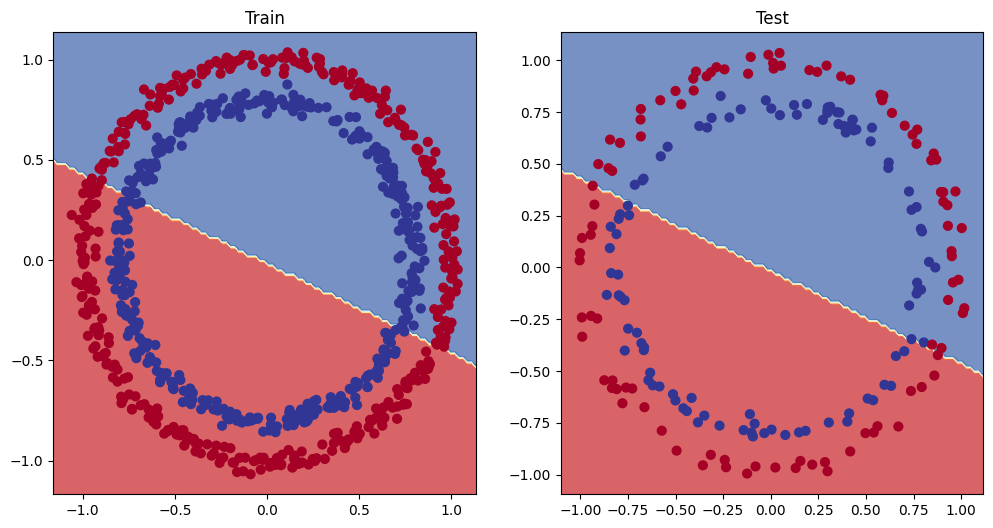

In [88]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

We can see that the model boundary created by our function doesn't segregate the data at all. It's kinda bad at creating a boundary between the red and blue circles.

## 5. Improving a model (from a model perspective)

* Add more layers - Give the model more chances to learn patterns in data.
* Add more hidden units - Increase number of units in layer.
* Changing the activation functions used inside models.
* Changing our learning rate.
* Change the loss function.
* Use a better optimizer.

These options are all from a model's perspective but because they deal with the model, rather than the data.

And because these options are all values, we can change them. They are referred to as **hyperparameters**.

Let's try and improve our model by -
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [89]:
class CircleModelV1(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(2, 10)
    self.layer2 = nn.Linear(10, 10)
    self.layer3 = nn.Linear(10, 1)

  def forward(self, x):
    # z = self.layer1(x)
    # z = self.layer2(z)
    # z = self.layer3(z)
    return self.layer3(self.layer2(self.layer1(x))) # Leverages speedups behind the scenes where possible.

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [90]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer1 = torch.optim.SGD(model_1.parameters(),
                             lr=0.01)

In [91]:
# Creating a training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  # Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  train_loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # Gradients to zero
  optimizer1.zero_grad()

  # Backpropagate
  train_loss.backward()

  # Update weights
  optimizer1.step()

  # Testing
  if epoch%50 == 0:
    model_1.eval()
    with torch.inference_mode():
      # Forward pass
      test_logits = model_1(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))

      # Calculate loss
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

      print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.5f}, Train Accuracy: {acc:.2f}% |\
       Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%')

Epoch: 1 | Train Loss: 0.69396, Train Accuracy: 50.88% |       Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 51 | Train Loss: 0.69381, Train Accuracy: 50.75% |       Test Loss: 0.69264, Test Accuracy: 50.50%
Epoch: 101 | Train Loss: 0.69369, Train Accuracy: 50.25% |       Test Loss: 0.69269, Test Accuracy: 50.00%
Epoch: 151 | Train Loss: 0.69359, Train Accuracy: 50.00% |       Test Loss: 0.69275, Test Accuracy: 50.50%
Epoch: 201 | Train Loss: 0.69351, Train Accuracy: 50.12% |       Test Loss: 0.69282, Test Accuracy: 49.50%
Epoch: 251 | Train Loss: 0.69345, Train Accuracy: 50.25% |       Test Loss: 0.69288, Test Accuracy: 50.50%
Epoch: 301 | Train Loss: 0.69339, Train Accuracy: 50.50% |       Test Loss: 0.69295, Test Accuracy: 49.00%
Epoch: 351 | Train Loss: 0.69334, Train Accuracy: 50.38% |       Test Loss: 0.69302, Test Accuracy: 49.00%
Epoch: 401 | Train Loss: 0.69329, Train Accuracy: 50.38% |       Test Loss: 0.69309, Test Accuracy: 48.50%
Epoch: 451 | Train Loss: 0.69326, Train 

We see that out model is still not learning anything. This is because of the linear nature of the model. It has 0 non-linear functions.

Let's plot the decision boundary again.

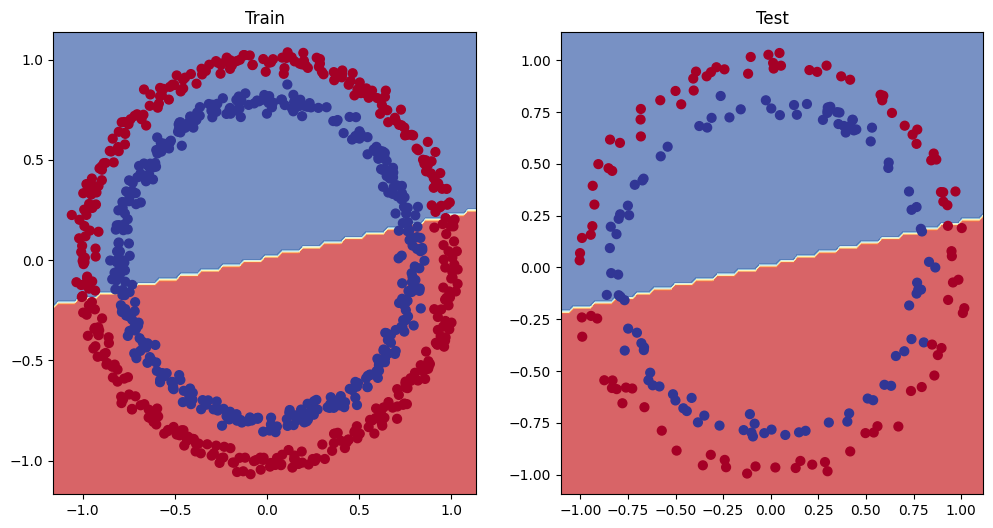

In [92]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [93]:
# Set parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = X_regression * weight + bias

# Checking data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [94]:
# Create train test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression)

(80, 80)

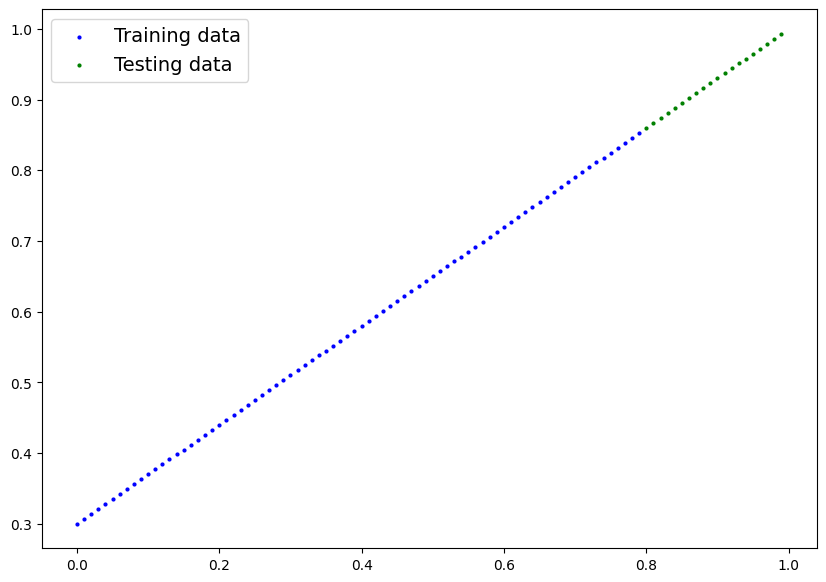

In [95]:
# Function was already imported from helper_functions.py
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [96]:
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit straight line data

In [97]:
# Lets create the same model with sequential with correct input and output dimensions
model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10,10),
    nn.Linear(10,1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [98]:
# Loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [99]:
# Train the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Move data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

  model_2.train()

  train_preds = model_2(X_train_regression)

  train_loss = loss_fn(train_preds, y_train_regression)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    if(epoch%50 == 0):
      test_preds = model_2(X_test_regression)
      test_loss = loss_fn(test_preds, y_test_regression)

      print(f'Epoch: {epoch} | Training Loss: {train_loss:.5f} | Testing Loss: {test_loss:.5f}')

Epoch: 0 | Training Loss: 0.75986 | Testing Loss: 0.91103
Epoch: 50 | Training Loss: 0.03196 | Testing Loss: 0.00108
Epoch: 100 | Training Loss: 0.02858 | Testing Loss: 0.00081
Epoch: 150 | Training Loss: 0.02744 | Testing Loss: 0.00169
Epoch: 200 | Training Loss: 0.02533 | Testing Loss: 0.00209
Epoch: 250 | Training Loss: 0.02331 | Testing Loss: 0.00254
Epoch: 300 | Training Loss: 0.02137 | Testing Loss: 0.00305
Epoch: 350 | Training Loss: 0.01926 | Testing Loss: 0.00359
Epoch: 400 | Training Loss: 0.01964 | Testing Loss: 0.00341
Epoch: 450 | Training Loss: 0.01937 | Testing Loss: 0.00327
Epoch: 500 | Training Loss: 0.01940 | Testing Loss: 0.00387
Epoch: 550 | Training Loss: 0.01919 | Testing Loss: 0.00380
Epoch: 600 | Training Loss: 0.01903 | Testing Loss: 0.00379
Epoch: 650 | Training Loss: 0.01889 | Testing Loss: 0.00378
Epoch: 700 | Training Loss: 0.01878 | Testing Loss: 0.00381
Epoch: 750 | Training Loss: 0.01845 | Testing Loss: 0.00320
Epoch: 800 | Training Loss: 0.01840 | Testi

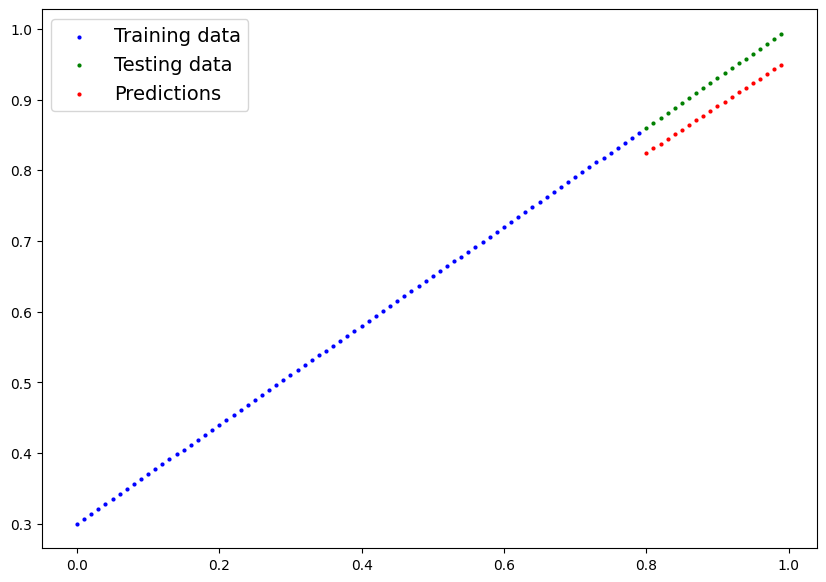

In [100]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines"

In machine learning terms, an infinite (but really it's finite) amount of linear and non-linear functions.

### 6.1 Recreating non-linear data (red and blue circles)

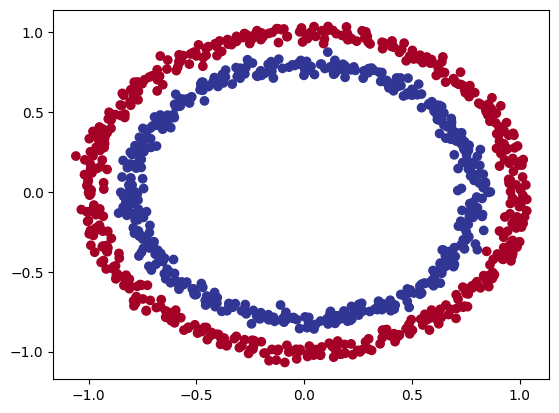

In [164]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [165]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn our data into tensors
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [166]:
from torch import nn

class CircleModelV2(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(2, 10)
    self.layer2 = nn.Linear(10, 10)
    self.layer3 = nn.Linear(10, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [167]:
# Setting our loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3 Training model with non-linearity

In [168]:
# Setting up device agnostic code.
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Moving the data to appropriate device.
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [169]:
# Setting epochs
epochs = 1000

for epoch in range(epochs):
  model_3.train()

  # 1. Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # 2. Loss and Accuracy
  train_loss = loss_fn(y_logits, y_train)
  train_accuracy = accuracy_fn(y_train, y_preds)

  # 3. Setting gradients to zero
  optimizer.zero_grad()

  # 4. Backpropagation
  train_loss.backward()

  # 5. Update parameters
  optimizer.step()

  # Testing Mode
  model_3.eval()
  with torch.inference_mode():
    if epoch%50 == 0:

      y_test_logits = model_3(X_test).squeeze()
      y_test_preds = torch.round(torch.sigmoid(y_test_logits))

      test_loss = loss_fn(y_test_logits, y_test)
      test_accuracy = accuracy_fn(y_test, y_test_preds)

      print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Accuracy: {train_accuracy:.3f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.3f}')

Epoch: 0 | Train Loss: 0.70016, Train Accuracy: 50.000 | Test Loss: 0.70032, Test Accuracy: 50.000
Epoch: 50 | Train Loss: 0.69223, Train Accuracy: 49.875 | Test Loss: 0.69317, Test Accuracy: 45.500
Epoch: 100 | Train Loss: 0.69095, Train Accuracy: 51.375 | Test Loss: 0.69201, Test Accuracy: 49.500
Epoch: 150 | Train Loss: 0.68998, Train Accuracy: 53.000 | Test Loss: 0.69109, Test Accuracy: 56.500
Epoch: 200 | Train Loss: 0.68889, Train Accuracy: 56.250 | Test Loss: 0.69003, Test Accuracy: 56.500
Epoch: 250 | Train Loss: 0.68711, Train Accuracy: 59.000 | Test Loss: 0.68833, Test Accuracy: 54.500
Epoch: 300 | Train Loss: 0.68526, Train Accuracy: 63.000 | Test Loss: 0.68680, Test Accuracy: 62.500
Epoch: 350 | Train Loss: 0.68330, Train Accuracy: 70.375 | Test Loss: 0.68514, Test Accuracy: 71.000
Epoch: 400 | Train Loss: 0.68084, Train Accuracy: 71.250 | Test Loss: 0.68307, Test Accuracy: 74.000
Epoch: 450 | Train Loss: 0.67773, Train Accuracy: 72.125 | Test Loss: 0.68040, Test Accuracy: 

### 6.4 Evaluating a model with non-linear activation functions

In [171]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

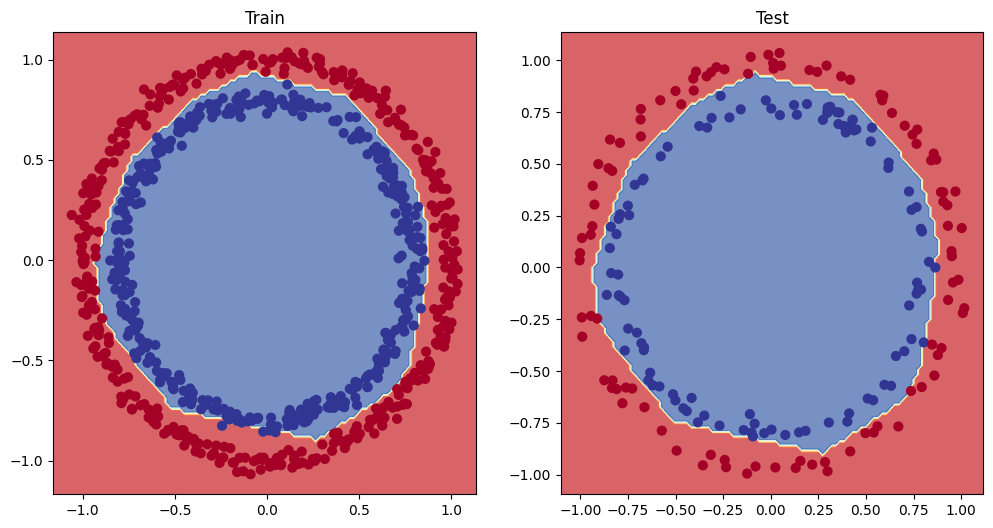

In [175]:
# Plotting decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)